In [93]:
import numpy as np
from petsc4py import PETSc
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

In [94]:
def load_petsc_vec(filename, comm=PETSc.COMM_SELF):
    """
    Load a PETSc Vec from a binary file using petsc4py.
    """
    viewer = PETSc.Viewer().createBinary(filename, 'r', comm=comm)
    vec = PETSc.Vec().create(comm=comm)
    vec.load(viewer)
    viewer.destroy()
    return vec

In [95]:
def save_petsc_vec(vec, filename, comm=PETSc.COMM_SELF):
    """
    Save a PETSc Vec to a binary file.
    """
    viewer = PETSc.Viewer().createBinary(filename, 'w', comm=comm)
    vec.view(viewer)
    viewer.destroy()

In [96]:
def vec_to_array_2d3(vec, Nx, Ny, dof=3):
    """
    Convert a PETSc Vec to a NumPy array of shape (Ny, Nx, dof).

    Assumes standard DMDA / IGA lexicographic ordering with x fastest,
    then y, and 'dof' components per node.

    total_size = Nx * Ny * dof  (this is checked).
    """
    Nglobal = vec.getSize()
    expected = Nx * Ny * dof
    if Nglobal != expected:
        raise ValueError(
            f"Global Vec size {Nglobal} != Nx*Ny*dof = {expected} "
            f"(Nx={Nx}, Ny={Ny}, dof={dof})"
        )

    # Get a copy of the global array
    arr_1d = vec.getArray().copy()
    # Reshape to (Ny, Nx, dof); x is fastest, then y
    arr = arr_1d.reshape((Ny, Nx, dof))
    return arr

In [97]:
def array_2d3_to_vec(arr, comm=PETSc.COMM_SELF):
    """
    Convert a NumPy array of shape (Ny, Nx, dof) to a PETSc Vec
    with the same global layout (x fastest, then y, then dof).
    """
    Ny, Nx, dof = arr.shape
    Nglobal = Nx * Ny * dof

    vec = PETSc.Vec().create(comm=comm)
    vec.setSizes(Nglobal)
    vec.setFromOptions()

    flat = arr.reshape(-1)
    vec.setArray(flat.copy())
    return vec

In [98]:
def compute_signed_distance(binary_mask, dx=1.0, dy=1.0):
    """
    Compute a signed distance field from a binary mask.

    binary_mask: bool array where True = "inside" (e.g., ice)
    dx, dy:     grid spacing in x and y (for physical scaling)

    Returns:
        signed_dist (same shape as mask): negative inside, positive outside.
    """
    # Distance to boundary from inside and outside
    # distance_transform_edt computes distance in pixel units to the nearest zero.
    # Standard SDF construction:
    #   dist_outside = distance to closest True (inside)
    #   dist_inside  = distance to closest False (outside)
    # Then signed_dist = dist_outside - dist_inside
    # so that it is negative inside, positive outside.
    inside = binary_mask
    outside = ~binary_mask

    # For anisotropic grid, you can pass sampling=(dy, dx)
    dist_outside = distance_transform_edt(outside, sampling=(dy, dx))
    dist_inside  = distance_transform_edt(inside,  sampling=(dy, dx))

    signed_dist = dist_outside - dist_inside
    return signed_dist

In [99]:
def reinitialize_phasefield_from_levelset(signed_dist, eps_new):
    """
    Given a signed distance field 'signed_dist' and a desired interface width eps_new,
    reconstruct a smooth phase-field using a tanh profile.

    We use the usual Cahn-Hilliard-style profile:
        phi(x) = 0.5 * (1 - tanh( s / (sqrt(2)*eps_new) ))
    where s < 0 is "inside" (phi ~ 1), s > 0 is "outside" (phi ~ 0).
    """
    return 0.5 * (1.0 - np.tanh(signed_dist / (np.sqrt(2.0) * eps_new)))

In [100]:
def reinitialize_ice_phase(
    infile,
    outfile,
    Nx,
    Ny,
    Lx,
    Ly,
    eps_new,
    threshold=0.5,
    dof=3,
    ice_idx=0,
    sed_idx=1,
    temp_idx=2,
    comm=PETSc.COMM_SELF,
    plot=False,
):
    """
    High-level driver:

    - infile:    existing PETSc Vec file (e.g., [ice, sediment, temp])
    - outfile:   output PETSc Vec file with *reinitialized ice only*
    - Nx, Ny:    grid dimensions
    - Lx, Ly:    physical domain size (for dx, dy)
    - eps_new:   desired interface width for reconstructed phase-field
    - threshold: binarization threshold for current ice field
    - dof:       number of dofs (default 3: ice, sediment, temp)
    - ice_idx:   component index for ice in the Vec (default 0)
    - sed_idx:   component index for sediment in the Vec (default 1)
    - temp_idx:  component index for temperature in the Vec (default 2)

    NOTE:
    Only the ice component (ice_idx) is reinitialized. Sediment and
    temperature components are carried through unchanged from the input
    solution vector.
    """
    print(f"Loading Vec from {infile} ...")
    vec_in = load_petsc_vec(infile, comm=comm)

    print("Converting Vec to array (Ny, Nx, dof)...")
    arr = vec_to_array_2d3(vec_in, Nx=Nx, Ny=Ny, dof=dof)

    # Extract existing fields using explicit component indices
    ice      = arr[:, :, ice_idx]
    sediment = arr[:, :, sed_idx]
    temp     = arr[:, :, temp_idx]  # passed through unchanged

    # Grid spacing (approx). You can adjust this to match your IGA discretization
    dx = Lx / Nx
    dy = Ly / Ny

    print("Binarizing ice phase...")
    ice_binary = ice >= threshold

    print("Computing signed distance field...")
    signed_dist = compute_signed_distance(ice_binary, dx=dx, dy=dy)

    print(f"Reinitializing ice phase with eps_new = {eps_new:.3e} ...")
    ice_new = reinitialize_phasefield_from_levelset(signed_dist, eps_new=eps_new)

    # Clamp to [0,1] just for safety
    ice_new = np.clip(ice_new, 0.0, 1.0)

    if plot:
        print("Generating diagnostic plots...")
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        im0 = axes[0].imshow(ice, origin="lower")
        axes[0].set_title("Original ice")
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        im1 = axes[1].imshow(ice_binary.astype(float), origin="lower")
        axes[1].set_title(f"Binary ice (thr={threshold:.2f})")
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        im2 = axes[2].imshow(signed_dist, origin="lower")
        axes[2].set_title("Signed distance")
        fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

        im3 = axes[3].imshow(ice_new, origin="lower")
        axes[3].set_title("Reinitialized ice")
        fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    # Assemble new array: overwrite only the ice component; keep sed/temp as-is
    arr_new = arr.copy()
    arr_new[:, :, ice_idx] = ice_new
    arr_new[:, :, sed_idx] = sediment
    arr_new[:, :, temp_idx] = temp

    print(f"Ice (new)    range: [{ice_new.min():.3e}, {ice_new.max():.3e}]")
    print(f"Sediment      range: [{sediment.min():.3e}, {sediment.max():.3e}]")
    print(f"Temperature   range: [{temp.min():.3e}, {temp.max():.3e}]")
    print("Converting array back to Vec ...")
    vec_out = array_2d3_to_vec(arr_new, comm=comm)

    print(f"Saving reinitialized Vec to {outfile} ...")
    save_petsc_vec(vec_out, outfile, comm=comm)

    # Also save a VTK visualization file using the chosen component indices
    vtkfile = outfile.replace(".dat", ".vtk")
    print(f"Saving VTK file to {vtkfile} ...")
    save_vtk_image(
        vtkfile,
        arr_new[:, :, ice_idx],
        arr_new[:, :, sed_idx],
        arr_new[:, :, temp_idx],
        Lx,
        Ly,
    )

    # Clean up PETSc Vecs
    vec_in.destroy()
    vec_out.destroy()

    print("Done.")

In [101]:
def save_vtk_image(filename, ice, sediment, temp, Lx, Ly):
    """
    Save 2D fields (Ny × Nx) to a legacy VTK file readable by ParaView.

    ice, sediment, temp: 2D numpy arrays
    Lx, Ly: physical domain size (used to compute grid spacing)
    """
    Ny, Nx = ice.shape
    dx = Lx / Nx
    dy = Ly / Ny

    with open(filename, "w") as f:
        f.write("# vtk DataFile Version 3.0\n")
        f.write("Reinitialized Phase Field Output\n")
        f.write("ASCII\n")
        f.write("DATASET STRUCTURED_POINTS\n")
        f.write(f"DIMENSIONS {Nx} {Ny} 1\n")
        f.write(f"ORIGIN 0 0 0\n")
        f.write(f"SPACING {dx} {dy} 1\n")
        f.write(f"POINT_DATA {Nx * Ny}\n")

        # Ice field
        f.write("SCALARS IcePhase double 1\n")
        f.write("LOOKUP_TABLE default\n")
        for j in range(Ny):
            row = ice[j, :]
            f.write(" ".join(f"{val:.6e}" for val in row) + "\n")

        # Sediment field
        f.write("SCALARS SedPhase double 1\n")
        f.write("LOOKUP_TABLE default\n")
        for j in range(Ny):
            row = sediment[j, :]
            f.write(" ".join(f"{val:.6e}" for val in row) + "\n")

        # Temperature field
        f.write("SCALARS Temperature double 1\n")
        f.write("LOOKUP_TABLE default\n")
        for j in range(Ny):
            row = temp[j, :]
            f.write(" ".join(f"{val:.6e}" for val in row) + "\n")

    print(f"VTK file written to: {filename}")

In [102]:
def check_vtk_scalar_counts(path):
    with open(path, "r") as f:
        lines = f.readlines()

    # Find DIMENSIONS and POINT_DATA
    dims_line = next(l for l in lines if l.startswith("DIMENSIONS"))
    _, nx, ny, nz = dims_line.split()
    nx, ny, nz = int(nx), int(ny), int(nz)

    pd_line = next(l for l in lines if l.startswith("POINT_DATA"))
    _, npts = pd_line.split()
    npts = int(npts)

    print(f"DIMENSIONS: {nx} x {ny} x {nz}, POINT_DATA: {npts}")
    assert npts == nx * ny * nz, "POINT_DATA != DIMENSIONS product!"

    # Count how many float tokens each SCALARS block has
    i = lines.index(pd_line) + 1
    while i < len(lines):
        if lines[i].startswith("SCALARS"):
            name = lines[i].split()[1]
            i += 1  # skip LOOKUP_TABLE
            assert lines[i].startswith("LOOKUP_TABLE")
            i += 1
            values = []
            while i < len(lines) and not lines[i].startswith("SCALARS"):
                values.extend(lines[i].split())
                i += 1
            print(f"{name}: found {len(values)} values")
            assert len(values) == npts, f"{name} has wrong number of values"
        else:
            i += 1

Loading Vec from /Users/jacksonbaglino/PetIGA-3.20/projects/permafrost/inputs/tests/SthavisthaInputs/AssemblePhase.dat ...
Converting Vec to array (Ny, Nx, dof)...
Binarizing ice phase...
Computing signed distance field...
Reinitializing ice phase with eps_new = 9.300e-07 ...
Generating diagnostic plots...


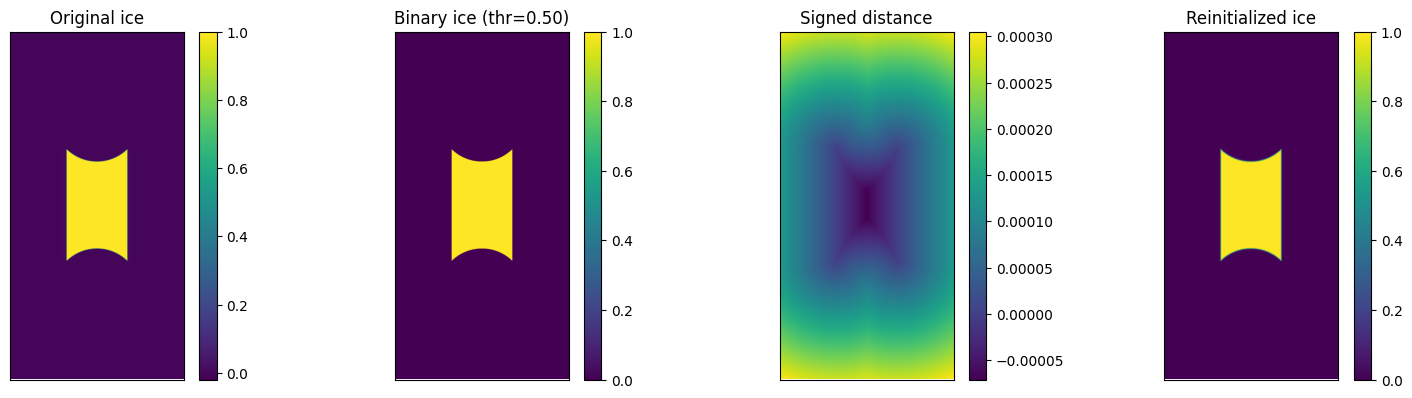

Ice (new)    range: [0.000e+00, 1.000e+00]
Sediment      range: [-8.370e-07, 1.000e+00]
Temperature   range: [0.000e+00, 0.000e+00]
Converting array back to Vec ...
Saving reinitialized Vec to /Users/jacksonbaglino/PetIGA-3.20/projects/permafrost/inputs/tests/SthavisthaInputs/AssemblePhase_reinit.dat ...
Saving VTK file to /Users/jacksonbaglino/PetIGA-3.20/projects/permafrost/inputs/tests/SthavisthaInputs/AssemblePhase_reinit.vtk ...
VTK file written to: /Users/jacksonbaglino/PetIGA-3.20/projects/permafrost/inputs/tests/SthavisthaInputs/AssemblePhase_reinit.vtk
Done.
DIMENSIONS: 869 x 1737 x 1, POINT_DATA: 1509453
IcePhase: found 1509453 values
SedPhase: found 1509453 values
Temperature: found 1509453 values


In [103]:
if __name__ == "__main__":
    # Example usage – change these to match your case
    infile  = "/Users/jacksonbaglino/PetIGA-3.20/projects/permafrost/inputs/tests/SthavisthaInputs/AssemblePhase.dat"
    outfile = "/Users/jacksonbaglino/PetIGA-3.20/projects/permafrost/inputs/tests/SthavisthaInputs/AssemblePhase_reinit.dat"

    Nx = 217*4+1
    Ny = 434*4+1
    Lx = 4.04e-4
    Ly = 8.08e-4

    eps_new   = 9.3e-7   # your target epsilon
    threshold = 0.5

    reinitialize_ice_phase(
        infile=infile,
        outfile=outfile,
        Nx=Nx,
        Ny=Ny,
        Lx=Lx,
        Ly=Ly,
        eps_new=eps_new,
        threshold=threshold,
        dof=3,
        ice_idx=0,
        sed_idx=1,
        temp_idx=2,
        comm=PETSc.COMM_SELF,
        plot=True,
    )

    vtkfile = outfile.replace(".dat", ".vtk")
    check_vtk_scalar_counts(path=vtkfile)